# Notebook "8_b_Besoin_2_Pistes_exploration_2"


## Description

Ce notebook se focalise sur la seconde piste d'exploration sur l'analyse des données Ineris : l'analyse des échantillons après soustraction du bruit blanc.

## Structure du notebook

Ce notebook est construit de plusieurs parties :
- I. Import des bibliothèques
- II. Preprocessing des données
- III. Soustraire le blanc

## Prérequis

### Source de données

Pour que le notebook fonctionne, la base de données "INERIS" doit être disponible dans le même fichier que le notebook. Par ailleurs, cette source doit être au format csv avec le nom "DB_INERIS.csv"

### Installation des prérequis techniques

Le notebook fonctionne sur Python 3.7 avec les bibliothèques suivantes :
- pandas
- seaborn
- matplotlib
- numpy
- scipy
- sklearn

# I. Import des libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import scipy.stats as SS
from sklearn.metrics.pairwise import cosine_similarity
import datetime as dt
from scipy import stats

# II. Préprocessing des données

## II.a Définition des variables

In [2]:
substances = ['2378-TCDD', '12378-PeCDD', '123478-HxCDD', '123678-HxCDD',
       '123789-HxCDD', '1234678-HpCDD', 'OCDD', '2378-TCDF', '12378-PeCDF',
       '23478-PeCDF', '123478-HxCDF', '123678-HxCDF', '234678-HxCDF',
       '123789-HxCDF', '1234678-HpCDF', '1234789-HpCDF', 'OCDF']

substances_A = [sub + '_A' for sub in substances]
substances_C = [sub + '_C' for sub in substances]

total_homologue = ['Total TCDD', 'Total PeCDD', 'Total HxCDD', 'Total HpCDD', 'OCDD', 
    'Total TCDF', 'Total PeCDF', 'Total HxCDF', 'Total HpCDF', 'OCDF']

total_dioxine = ['Total TCDD', 'Total PeCDD', 'Total HxCDD', 'Total HpCDD', 'Total DIOXINE']
total_furanne = ['Total TCDF', 'Total PeCDF', 'Total HxCDF', 'Total HpCDF', 'Total FURANE']

## II.b Chargement des données

In [3]:
data = pd.read_csv('DB_INERIS.csv', sep=';')

data['Type de point de mesure'].replace({"source":"Source"}, inplace=True)
data = data.replace('-', np.nan)
for col in (substances + total_homologue + ['Total DIOXINE', 'Total FURANE']):
    data[col] = data[col].astype(str)
    data[col] = [float(a.replace(',', '.')
                        .replace('94.759.846', "94759.846")
                        .replace('<', '')
                        .replace('ND', '0')
                        .replace('?', '.')
                        .replace(';', '.')
                        .replace('ç', '9')) for a in data[col].values]

## II.c Définition des colonnes

In [4]:
columns_process = ['2378-TCDD', '<', '12378-PeCDD', '<.1', '123478-HxCDD',
       '<.2', '123678-HxCDD', '<.3', '123789-HxCDD', '<.4', '1234678-HpCDD',
       '<.5', 'OCDD', '<.6', '2378-TCDF', '<.7', '12378-PeCDF',
       '<.8', '23478-PeCDF', '<.9', '123478-HxCDF', '<.10', '123678-HxCDF',
       '<.11', '234678-HxCDF', '<.12', '123789-HxCDF', '<.13', '1234678-HpCDF',
       '<.14', '1234789-HpCDF', '<.15', 'OCDF', '<.16',
       'Total TCDD', '<.17', 'Total PeCDD', '<.18', 'Total HxCDD', '<.19',
       'Total HpCDD', '<.20', 'Total DIOXINE', '<.21', 'Total TCDF', '<.22',
       'Total PeCDF', '<.23', 'Total HxCDF', '<.24', 'Total HpCDF', '<.25',
       'Total FURANE', '<.26']

for col in columns_process:
    if '<' in col:
        coef = []
        for a in data[col].values:
            if(a == '<' or a == 'ND' or a == 0 or a == '0'):
                coef.append(0)
            else:
                coef.append(1)
        data[old_col] = data[old_col] * coef
    else:
        old_col = col


## II.d Mise en place de la normalisation A

In [5]:
table_final = data.copy()
table_final["total sub 2378"] = 0
for sub in substances:
    table_final["total sub 2378"] += table_final[sub]

In [6]:
table_norme_A = table_final.copy()
for sub in substances:
    table_norme_A[sub + '_A'] = table_norme_A[sub]  / table_final["total sub 2378"]

## II.e Mise en place de la normalisation C

In [7]:
table_total = table_norme_A[["Nom du projet", "Type de point de mesure", "Matrice", "Contexte", "Source", "Fournisseur", "Distance à la source (km)", "Année", "Date de mesure :  Début"] + substances + substances_A]
table_total = table_total[table_total["Fournisseur"] != "US EPA"]
table_total

,Nom du projet,Type de point de mesure,Matrice,Contexte,Source,Fournisseur,Distance à la source (km),Année,Date de mesure : Début,2378-TCDD,...,2378-TCDF_A,12378-PeCDF_A,23478-PeCDF_A,123478-HxCDF_A,123678-HxCDF_A,234678-HxCDF_A,123789-HxCDF_A,1234678-HpCDF_A,1234789-HpCDF_A,OCDF_A
0,SIVERT,Partiellement exposé,Air,Surveillance,UIOM,79279,1,2006.0,20/07/2006,0.02,...,0.008875,0.004113,0.013377,0.010044,0.009611,0.014027,0.000000,0.073726,0.004805,0.054937
1,SIVERT,Partiellement exposé,Air,Surveillance,UIOM,79279,1,2006.0,20/07/2006,0.02,...,0.304078,0.075516,0.203132,0.063421,0.051791,0.033494,0.000000,0.090091,0.003566,0.022949
2,SIVERT,Partiellement exposé,Air,Surveillance,UIOM,79279,1,2006.0,20/07/2006,0.02,...,0.003838,0.001962,0.007239,0.010074,0.008678,0.008111,0.000000,0.062361,0.029654,0.053639
3,SIVERT,Partiellement exposé,Air,Surveillance,UIOM,79279,1,2006.0,15/09/2006,0.19,...,0.071313,0.029173,0.067891,0.080497,0.067171,0.035476,0.000000,0.161354,0.019809,0.020890
4,SIVERT,Partiellement exposé,Air,Surveillance,UIOM,79279,1,2006.0,15/09/2006,0.55,...,0.002760,0.001990,0.005638,0.009642,0.008027,0.012684,0.000606,0.055538,0.008199,0.038877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,Essais sur déchets sauvages,Source,Emission,Incendie,Cables électriques,Essais sur déchets sauvages,0,2018.0,01/07/2018,77.49,...,0.008453,0.012109,0.034376,0.038210,0.031034,0.096115,0.031505,0.255975,0.046800,0.247354
816,Essais sur déchets sauvages,Blanc,Emission,Incendie,Blanc,Essais sur déchets sauvages,0,2018.0,01/07/2018,0.00,...,0.149447,0.118347,0.073680,0.034857,0.032979,0.031726,0.000000,0.060948,0.000000,0.180964
817,Essais sur déchets sauvages,Blanc,Emission,Incendie,Blanc,Essais sur déchets sauvages,0,2018.0,01/07/2018,0.00,...,0.032296,0.027385,0.029469,0.032892,0.029171,0.045840,0.000000,0.165203,0.060128,0.265665
818,Essais sur déchets sauvages,Source,Emission,Incendie,Cables électriques,Essais sur déchets sauvages,0,2018.0,01/07/2018,837.66,...,0.010952,0.015564,0.040471,0.057805,0.042571,0.106888,0.030228,0.153527,0.078567,0.169940


# III. Soustraire le blanc

## III.a Recherche de la campagne

In [8]:
data_sivert = table_total[(table_total["Nom du projet"] == "SIVERT") & (table_total["Matrice"] == "Jauge")].copy()
e = data_sivert.groupby(["Date de mesure :  Début"]).count()
list_campaigns = e.index
data_sivert["id_campaign"] = [list(list_campaigns).index(indice) for indice in data_sivert["Date de mesure :  Début"].values]

## III.b Construction du blanc aggrégé par campagne

In [9]:
blanc_min = data_sivert[data_sivert["Type de point de mesure"] == "Blanc"].groupby("id_campaign").max()
blanc_min = blanc_min.reset_index()
blanc_min = blanc_min[substances + ['id_campaign']]

## III.c Soustraction du blanc

In [10]:
data_transform = data_sivert[substances + ['id_campaign', "Type de point de mesure", "Distance à la source (km)"]].copy()
for index in range(len(data_transform)):
    data_transform.iloc[index] = list(data_transform.iloc[index][substances].values - blanc_min[blanc_min["id_campaign"] == data_transform.iloc[index]['id_campaign']][substances].values[0]) + [data_transform.iloc[index]['id_campaign'], data_transform.iloc[index]['Type de point de mesure'], data_transform.iloc[index]['Distance à la source (km)']]

In [11]:
data_transform_final = data_transform[(data_transform[substances] >= 0)]
data_transform_final["id_campaign"] = data_transform["id_campaign"]
data_transform_final["Type de point de mesure"] = data_transform["Type de point de mesure"]
data_transform_final["Distance à la source (km)"] = data_transform["Distance à la source (km)"]
data_transform_final = data_transform_final.fillna(0)
data_transform_final = data_transform_final.dropna()

## III.d Construction de la normalisation A

In [12]:
table_final_bis = data_transform_final.copy()
table_final_bis["total sub 2378"] = 0
for sub in substances:
    table_final_bis["total sub 2378"] += table_final_bis[sub]

In [13]:
table_norme_A_bis = table_final_bis.copy()
for sub in substances:
    table_norme_A_bis[sub + '_A'] = table_norme_A_bis[sub]  / table_final_bis["total sub 2378"]

In [14]:
table_norme_A_bis

,2378-TCDD,12378-PeCDD,123478-HxCDD,123678-HxCDD,123789-HxCDD,1234678-HpCDD,OCDD,2378-TCDF,12378-PeCDF,23478-PeCDF,...,2378-TCDF_A,12378-PeCDF_A,23478-PeCDF_A,123478-HxCDF_A,123678-HxCDF_A,234678-HxCDF_A,123789-HxCDF_A,1234678-HpCDF_A,1234789-HpCDF_A,OCDF_A
47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,0.00,0.00,0.00,0.00,0.00,4.38,21.74,0.17,0.00,0.00,...,0.006386,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.008640,0.000000,0.003757
49,0.00,0.00,0.00,0.00,0.00,2.23,16.01,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.013853,0.000000,0.050282
50,0.00,0.00,0.00,0.11,0.00,13.51,62.53,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.054778,0.0,0.578204,0.000000,0.029802
51,0.19,0.00,0.00,0.00,0.00,3.74,27.47,0.13,0.28,0.41,...,0.003566,0.007680,0.011245,0.006034,0.008228,0.007131,0.0,0.030993,0.005760,0.058146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.12,0.00,0.00,0.24,0.00,3.10,13.18,0.32,0.13,0.21,...,0.016145,0.006559,0.010595,0.000000,0.000000,0.000000,0.0,0.037841,0.010595,0.078708
214,0.20,0.30,0.14,0.75,0.32,9.19,67.50,0.42,0.07,0.18,...,0.004879,0.000813,0.002091,0.000000,0.000000,0.000000,0.0,0.022651,0.000000,0.058892
215,0.10,0.00,0.16,0.78,0.54,10.69,55.55,0.42,0.08,0.31,...,0.005642,0.001075,0.004164,0.000000,0.000000,0.000000,0.0,0.025927,0.004567,0.047555
216,0.18,0.14,0.00,0.00,0.00,2.47,12.13,0.29,0.10,0.16,...,0.016040,0.005531,0.008850,0.000000,0.000000,0.000000,0.0,0.030420,0.011615,0.102323


## III.e Visualisation du profil en fonction de l'exposition

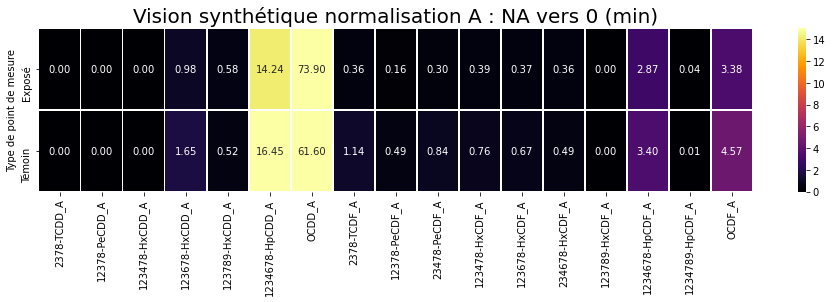

In [15]:
varexp = "Type de point de mesure"

visu = table_norme_A_bis[substances_A + [varexp]][table_norme_A_bis[varexp] != "Blanc"].groupby([varexp]).median()

f, ax = plt.subplots(figsize=(16, 3))
plt.title(f"Vision synthétique normalisation A : NA vers 0 (min)" , fontsize=20)
sns.heatmap(visu * 100, annot=True, fmt="04.2f", linewidths=.5, ax=ax, cmap = plt.cm.inferno, vmax = 15)

## III.f Visualisation du profil en fonction de la distance

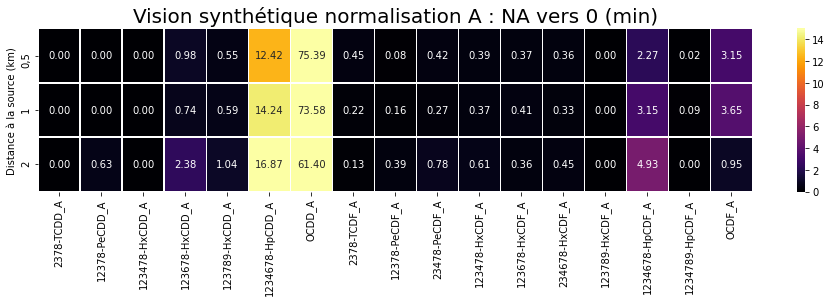

In [17]:
varexp = "Distance à la source (km)"

visu = table_norme_A_bis[table_norme_A_bis["Type de point de mesure"] == "Exposé"][substances_A + [varexp]].groupby([varexp]).median()

f, ax = plt.subplots(figsize=(16, 3))
plt.title(f"Vision synthétique normalisation A : NA vers 0 (min)" , fontsize=20)
sns.heatmap(visu * 100, annot=True, fmt="04.2f", linewidths=.5, ax=ax, cmap = plt.cm.inferno, vmax = 15)